In [8]:
from google.colab import files
files.upload()  # Choose kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"faizavenger","key":"bf1230a2c06dd96f612b5e2b091ecb5b"}'}

In [10]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [11]:
!pip install kaggle


In [12]:
!kaggle datasets download -d aadityasinghal/facial-expression-dataset


Dataset URL: https://www.kaggle.com/datasets/aadityasinghal/facial-expression-dataset
License(s): DbCL-1.0
  0% 0.00/60.7M [00:00<?, ?B/s]
100% 60.7M/60.7M [00:00<00:00, 702MB/s]


In [13]:
!unzip facial-expression-dataset.zip -d facial_expression_dataset


Streaming output truncated to the last 5000 lines.
  inflating: facial_expression_dataset/train/train/sad/Training_65242339.jpg  
  inflating: facial_expression_dataset/train/train/sad/Training_65267116.jpg  
  inflating: facial_expression_dataset/train/train/sad/Training_65275626.jpg  
  inflating: facial_expression_dataset/train/train/sad/Training_6529266.jpg  
  inflating: facial_expression_dataset/train/train/sad/Training_65329617.jpg  
  inflating: facial_expression_dataset/train/train/sad/Training_65338712.jpg  
  inflating: facial_expression_dataset/train/train/sad/Training_65338797.jpg  
  inflating: facial_expression_dataset/train/train/sad/Training_65387162.jpg  
  inflating: facial_expression_dataset/train/train/sad/Training_65404494.jpg  
  inflating: facial_expression_dataset/train/train/sad/Training_65426218.jpg  
  inflating: facial_expression_dataset/train/train/sad/Training_65430136.jpg  
  inflating: facial_expression_dataset/train/train/sad/Training_65437377.jpg  
  

In [14]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

In [15]:
TRAIN_DIR = "/content/facial_expression_dataset/train/train"

TEST_DIR = "/content/facial_expression_dataset/test/test"

In [16]:
import os
import pandas as pd

def load_dataset(directory):
    image_paths = []
    labels = []

    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)   # e.g., /train/happy
        if os.path.isdir(label_dir):                # make sure it's a folder
            for filename in os.listdir(label_dir):
                image_path = os.path.join(label_dir, filename)
                image_paths.append(image_path)
                labels.append(label)   # label = "happy", "sad", etc.

        print(label, "Completed ✅")

    return image_paths, labels



In [17]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

fear Completed ✅
neutral Completed ✅
angry Completed ✅
surprise Completed ✅
sad Completed ✅
disgust Completed ✅
happy Completed ✅


,image,label
0,/content/facial_expression_dataset/train/train...,neutral
1,/content/facial_expression_dataset/train/train...,happy
2,/content/facial_expression_dataset/train/train...,happy
3,/content/facial_expression_dataset/train/train...,sad
4,/content/facial_expression_dataset/train/train...,angry


In [18]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

fear Completed ✅
neutral Completed ✅
angry Completed ✅
surprise Completed ✅
sad Completed ✅
disgust Completed ✅
happy Completed ✅


,image,label
0,/content/facial_expression_dataset/test/test/f...,fear
1,/content/facial_expression_dataset/test/test/f...,fear
2,/content/facial_expression_dataset/test/test/f...,fear
3,/content/facial_expression_dataset/test/test/f...,fear
4,/content/facial_expression_dataset/test/test/f...,fear


<Axes: xlabel='count', ylabel='label'>

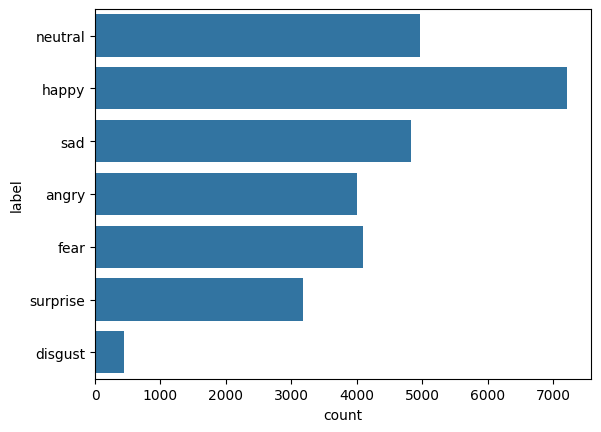

In [19]:

sns.countplot(train['label'])

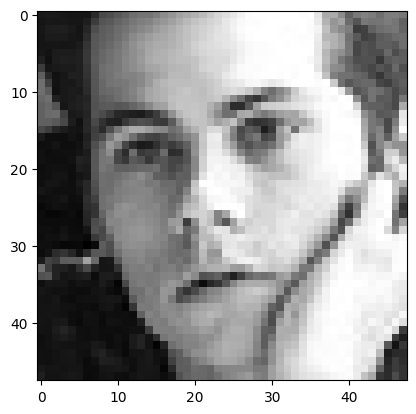

In [20]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray');

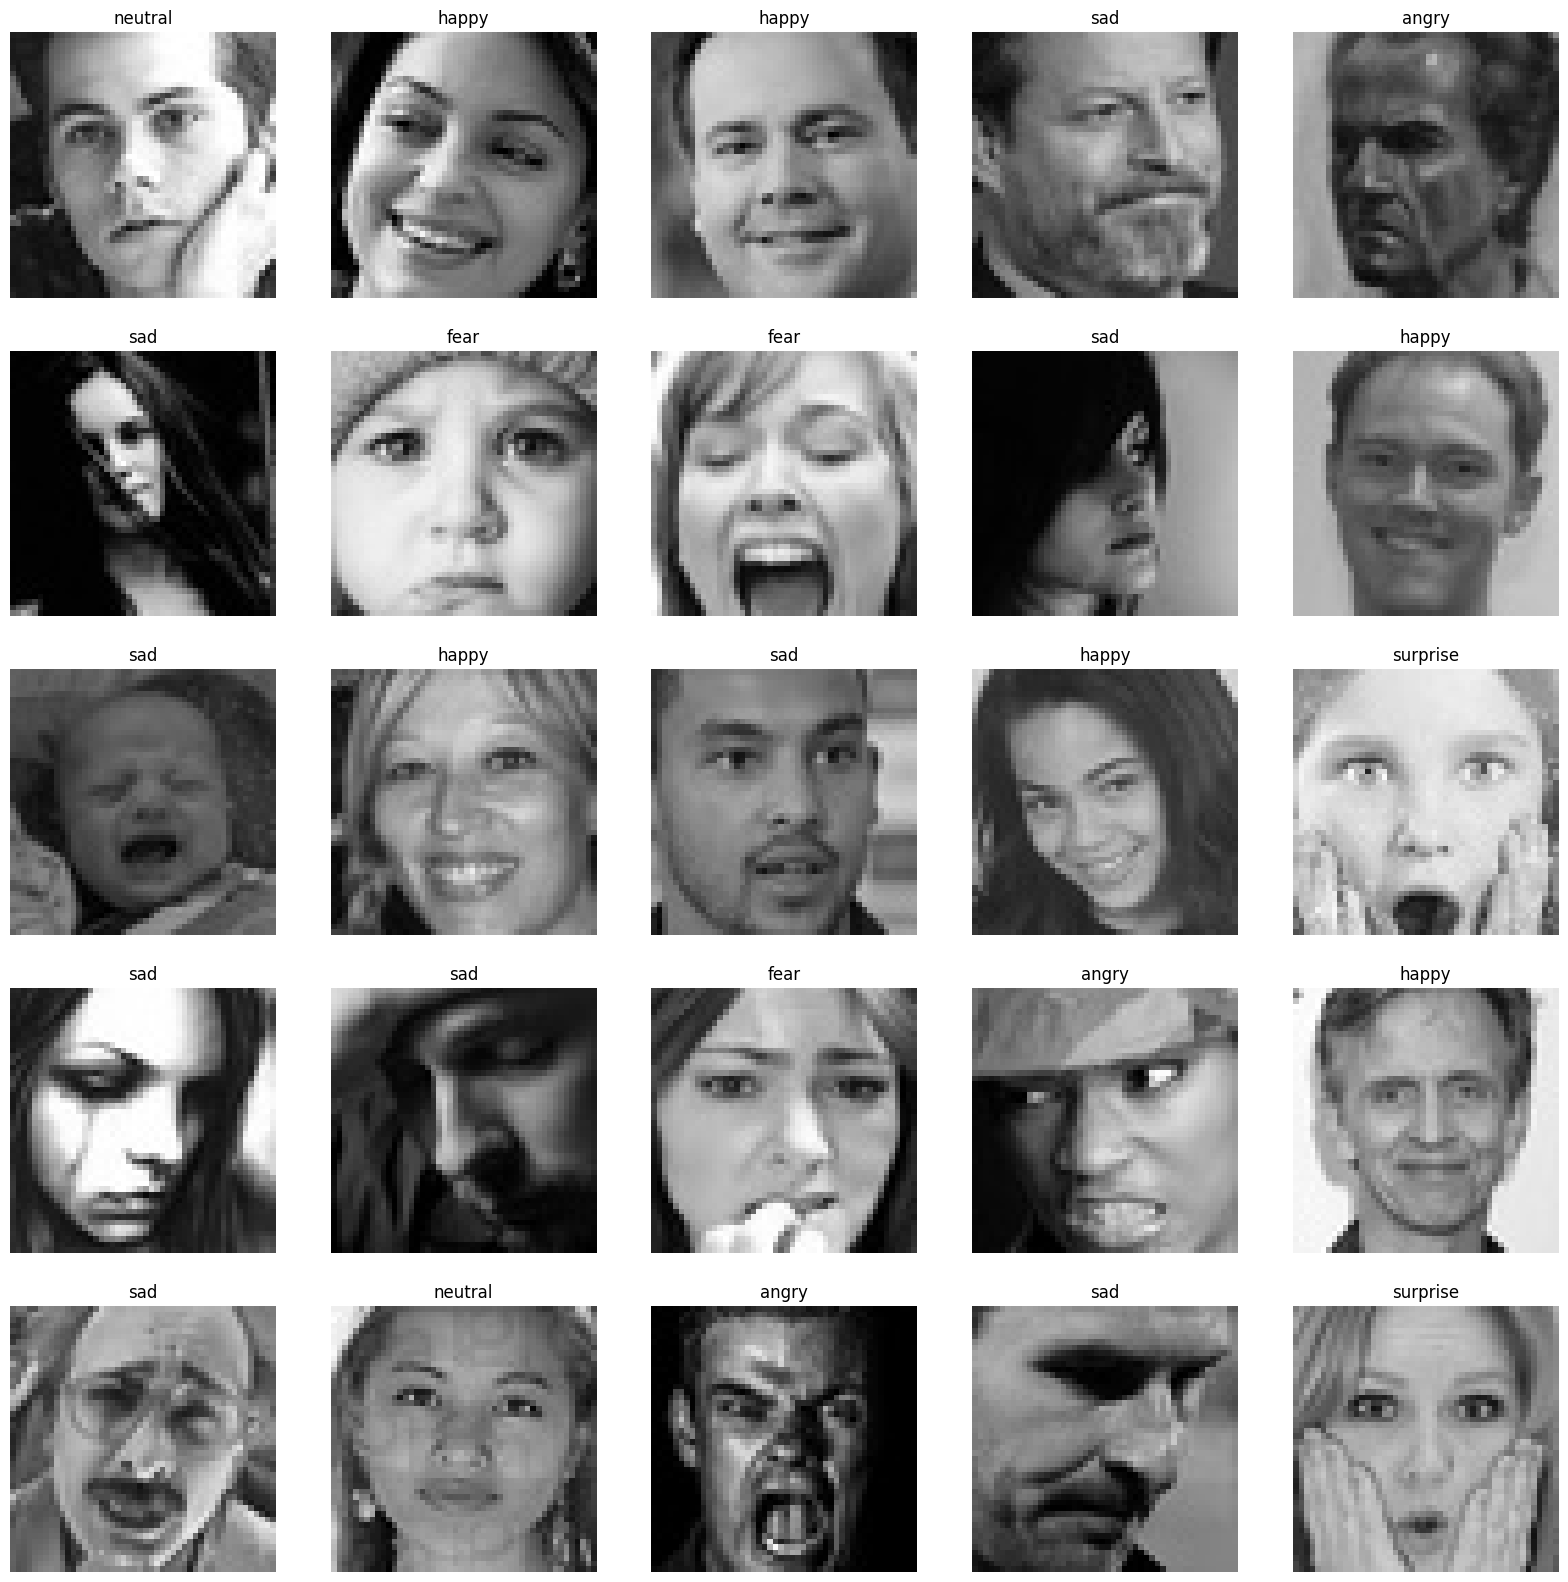

In [21]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

In [22]:
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode="grayscale", target_size=(48, 48))
        img = img_to_array(img) / 255.0   # normalize
        features.append(img)
    return np.array(features)


In [23]:
train_features = extract_features(train['image'])

100%|██████████| 28709/28709 [00:06<00:00, 4489.93it/s]


In [24]:
test_features = extract_features(test['image'])


100%|██████████| 7178/7178 [00:01<00:00, 6748.13it/s]


In [68]:
## normalize the image
x_train = train_features
x_test = test_features


In [26]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])


In [27]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [89]:
from sklearn.utils import class_weight
import numpy as np

y_integers = np.argmax(y_train, axis=1)  # convert back to integer labels

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_integers),
    y=y_integers
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: np.float64(1.0266046844269623), 1: np.float64(9.406618610747051), 2: np.float64(1.0010460615781582), 3: np.float64(0.5684387684387684), 4: np.float64(0.8260394187886635), 5: np.float64(0.8491274770777877), 6: np.float64(1.293372978330405)}


In [28]:
y_train[0]


array([0., 0., 0., 0., 1., 0., 0.])

In [29]:
# config
input_shape = (48, 48, 1)
output_class = 7


In [73]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [90]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

datagen.fit(x_train)


In [91]:
# train the model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(x_test, y_test),
    class_weight=class_weights
)


Epoch 1/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.3093 - loss: 1.9107 - val_accuracy: 0.4606 - val_loss: 1.4127
Epoch 2/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.3331 - loss: 1.7178 - val_accuracy: 0.4624 - val_loss: 1.4172
Epoch 3/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.3533 - loss: 1.6643 - val_accuracy: 0.4691 - val_loss: 1.4083
Epoch 4/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.3654 - loss: 1.6464 - val_accuracy: 0.4618 - val_loss: 1.4006
Epoch 5/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.3738 - loss: 1.6058 - val_accuracy: 0.4583 - val_loss: 1.4070
Epoch 6/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.3832 - loss: 1.5833 - val_accuracy: 0.4898 - val_loss: 1.3412
Epoch 7/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.3921 - loss: 1.5728 - val_accuracy: 0.4901 - val_loss: 1.3299
Epoch 8/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.4034 - loss: 1.5461 - 

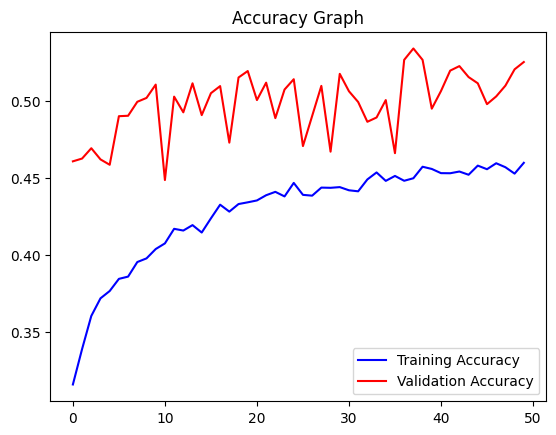

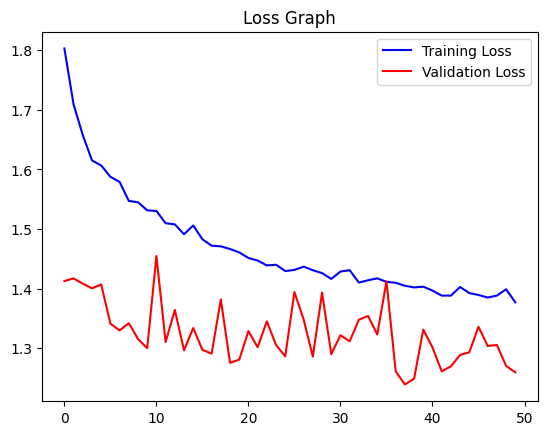

In [92]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()
plt.show()

Original Output: neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Output: neutral


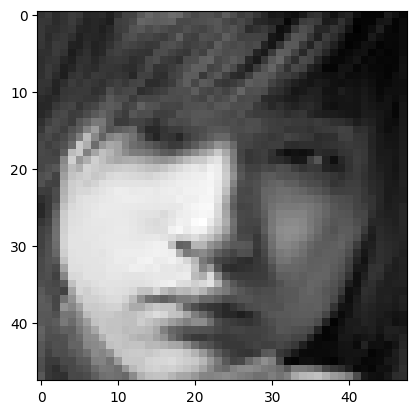

In [101]:
image_index = random.randint(0, len(test_features)-1)
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1,48,48,1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48,48), cmap='gray')



Original Output: happy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Output: happy


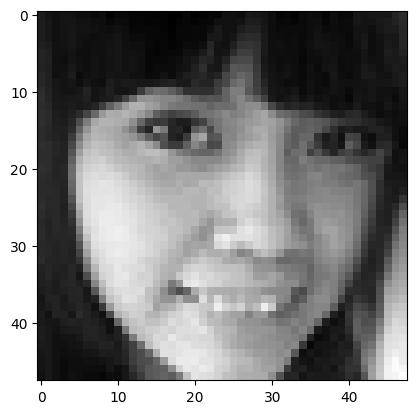

In [109]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');


Original Output: happy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Output: happy


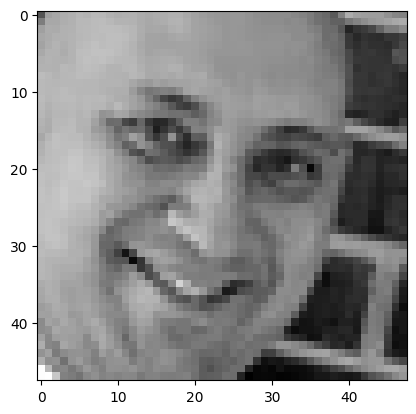

In [102]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');
